# Chicago taxi rides 

Our company, Zuber, is a new ride-sharing company that's launching in Chicago. Our task is to find patterns in the available information. We want to understand taxi passenger preferences and the impact of external factors on rides.
We will analyze data from taxi companies (competitors) and test a hypothesis about the impact of weather on rides.

**Project goal**:

To understand taxi passenger preferences and patterns and the impact of weather on rides duration. 

## Initialization and loading data on companies and neighborhoods 

In [1]:
# Loading all the libraries:
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns 

In [2]:
# Load the data files into DataFrames
companies = pd.read_csv('/datasets/project_sql_result_01.csv')
neighborhoods = pd.read_csv('/datasets/project_sql_result_04.csv')

## Preprocessing and studying data

### Companies

In [3]:
# view a sample of 15 top companies (with amount of trips on Nov 15-16, 2017): 
companies.head(15)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


It is noteworthy that between indices 13 and 14 there is a drop of more than 900 (almost 30% of the value of row 13). We will return to this point below.   

In [4]:
# general info of the companies data:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
company_name    64 non-null object
trips_amount    64 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [5]:
# general stats of the amount of trips per company:
companies['trips_amount'].describe()

count      64.00
mean     2145.48
std      3812.31
min         2.00
25%        20.75
50%       178.50
75%      2106.50
max     19558.00
Name: trips_amount, dtype: float64

In [6]:
# checking for explicit duplicates: 
companies.duplicated().sum()

0

We have 64 entries (no missing values and no explicit duplicates), each with taxi company_name, and it's number of rides on November 15-16, 2017. Datatypes are ok (str for company name, int for number of rides). The number of rides per company varies between 2 and 19,558, and according to the large difference between the median (178.5) and the mean (~2145.5) - the distribution is strongly right-skewed (the mean is even higher than the 3rd quartile (2106.5)).    

### Neighborhoods

In [7]:
# view a sample of top 15 dropoff neighborhoods (and the average number of rides
# that ended in each neighborhood in November 2017.)
neighborhoods.head(15)

,dropoff_location_name,average_trips
0,Loop,10727.47
1,River North,9523.67
2,Streeterville,6664.67
3,West Loop,5163.67
4,O'Hare,2546.90
5,Lake View,2420.97
6,Grant Park,2068.53
7,Museum Campus,1510.00
8,Gold Coast,1364.23
9,Sheffield & DePaul,1259.77


It is noteworrthy that indices 9-11 are similar in their average_trips values, then a drop of more than 300 (~25% of the value of row 11), and indices 12-14 are again similar in their average_trips values. We will return to this point below.   

In [8]:
# general info of the neighborhoods data: 
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
dropoff_location_name    94 non-null object
average_trips            94 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [9]:
# general stats of the average number of rides that ended in each neighborhood
neighborhoods['average_trips'].describe() 

count      94.00
mean      599.95
std      1714.59
min         1.80
25%        14.27
50%        52.02
75%       298.86
max     10727.47
Name: average_trips, dtype: float64

In [10]:
# checking for explicit duplicates: 
neighborhoods.duplicated().sum()

0

We have 94 entries (no missing values and no explicit duplicates), each with neighborhood name of dropoff location, and it's average number of rides on November 2017. Datatypes are ok (str for neighborhood name, float for average number of rides). The average number of rides per neighborhood varies between 1.8 and 10,727.47, and according to the large difference between the median (52.02) and the mean (almost 600) - the distribution is strongly right-skewed (the mean is double the 3rd quartile (~299)).    

##  Top 10 neighborhoods in terms of drop-offs

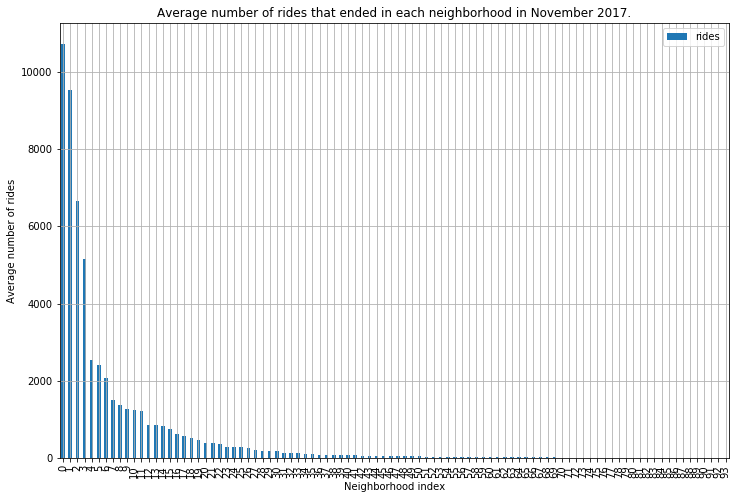

In [11]:
# bar plot of average rides that ended in each neighborhood:
neighborhoods.plot(kind='bar', grid=True, figsize=(12, 8))
plt.title('Average number of rides that ended in each neighborhood in November 2017.')
plt.ylabel('Average number of rides')
plt.xlabel('Neighborhood index')
plt.legend(['rides'])
plt.show;

The graph shows how the big majority of average number of rides is dropped off in just a few neighborhoods, while many neighborhoods are far less popular as drop off locaion. 

Only 4 neighborhoods are the destiny of more than 4000 rides in average, then only additional are 3 are above 2000, then only additonal 5 are above 1000. As also noticed in the sample above - between row 11 and 12 there is a drop from more than 1200 to less than 900. We will therefore choose 1200 rides on average as our line, under which we will group together all "less-destined" neighborhoods as "Other".     

In [16]:
# grouping together all the rows under 1200 average_trips as "Other":  
indices = neighborhoods[neighborhoods.average_trips < 1200].index
sum_av_of_trips = neighborhoods.loc[indices].average_trips.sum()
neighborhoods.drop(indices,axis=0,inplace=True)

temp_df = pd.DataFrame([['Other',sum_av_of_trips]],columns=neighborhoods.columns)
neighborhoods = pd.concat([neighborhoods,temp_df]).set_index('dropoff_location_name')
neighborhoods

,average_trips
dropoff_location_name,
Loop,10727.47
River North,9523.67
Streeterville,6664.67
West Loop,5163.67
O'Hare,2546.90
Lake View,2420.97
Grant Park,2068.53
Museum Campus,1510.00
Gold Coast,1364.23


Let's look now at the 'top destiny neighborhoods' shares of average number of rides: 

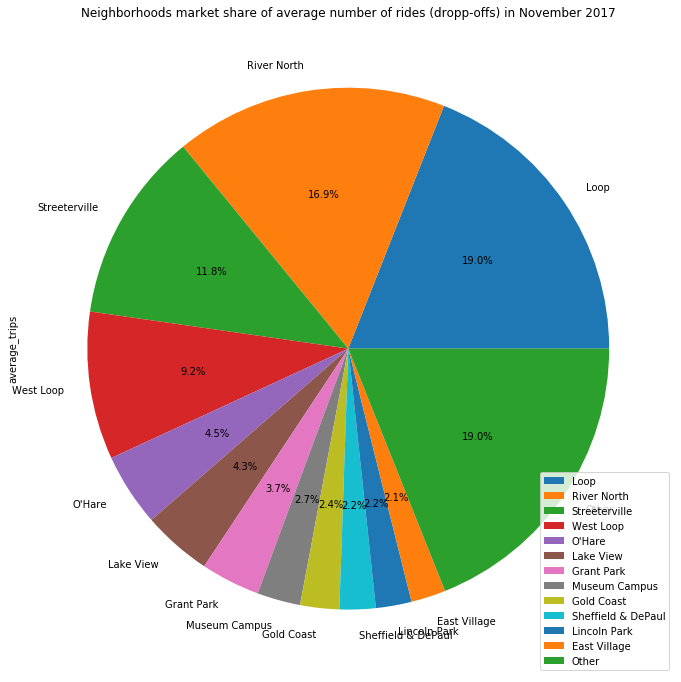

In [17]:
# pie plot of neighborhoods market share of average number of rides (drop-offs): 
neighborhoods.plot(kind='pie', y='average_trips', autopct='%1.1f%%', figsize=(15, 12))
plt.title('Neighborhoods market share of average number of rides (dropp-offs) in November 2017')
plt.legend(loc = 'lower right')
plt.show() 

4 neighborhoods (Loop, River North, Streeterville and West Loop) make together almost 57% of all rides drop-offs. The fifth (O'Hare) is the destiny of only 4.5% of the rides. 

**The top 10 neighborhoods in terms of drop-offs**

1. Loop --------------------19.0% of average number of rides (drop-offs)    
2. River North -----------16.9%
3. Streeterville -----------11.8%
4. West Loop --------------9.2%
5. O'Hare ------------------ 4.5%
6. Lake View ---------------4.3%
7. Grant Park ---------------3.7%
8. Museum Campus -------2.7%
9. Gold Coast ---------------2.4%
10. Sheffield & DePaul ------2.2%

and the next 2 are also close enogh to number 10:

11. Lincoln Park ------------2.2%
12. East Village ------------2.1%
13. Other (all the rest)----19.0%



## Taxi companies and number of rides

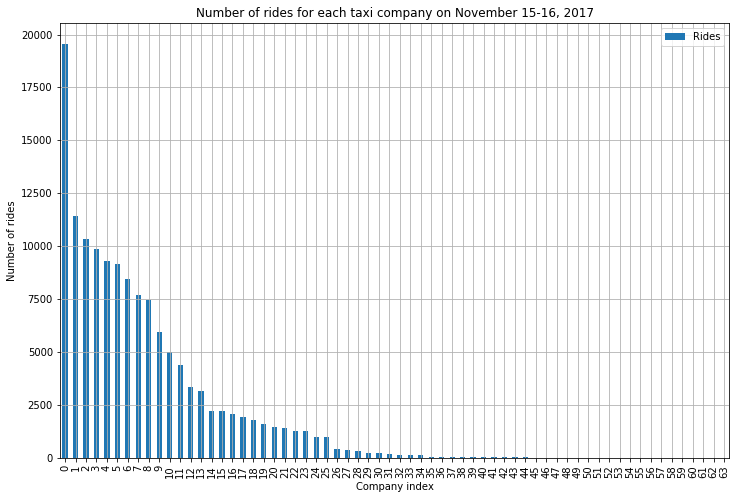

In [18]:
# bar plot of number of rides of each taxi company on November 15-16, 2017: 
companies.plot(kind='bar', grid=True, figsize=(12, 8))
plt.title('Number of rides for each taxi company on November 15-16, 2017')
plt.ylabel('Number of rides')
plt.xlabel('Company index')
plt.legend(['Rides'])
plt.show;

The graph shows how the big majority of rides are done by about 10 companies, while many companies make a relatively small amount of rides. 

One company (Flash cab) leads way ahead of all the rest (almost 20K rides in these two days), followed by 'Taxi Affiliation Services' with only around 11K rides, and the following 7 companies are above 7500 rides. Only 5 additional companies have more than 3000 rides, and as also noticed in the sample above - between row 13 and 14 there is a drop of around 30%. We will therefore choose 3000 rides as our line, under which we will group together all companies as "Other".  

In [19]:
# grouping together all companies with less than 3000 rides as "Other": 
indices = companies[companies.trips_amount < 3000].index
sum_of_trips = companies.loc[indices].trips_amount.sum()
companies.drop(indices,axis=0,inplace=True)

temp_df = pd.DataFrame([['Other',sum_of_trips]],columns=companies.columns)
companies = pd.concat([companies,temp_df]).set_index('company_name')
companies

,trips_amount
company_name,
Flash Cab,19558
Taxi Affiliation Services,11422
Medallion Leasing,10367
Yellow Cab,9888
Taxi Affiliation Service Yellow,9299
Chicago Carriage Cab Corp,9181
City Service,8448
Sun Taxi,7701
Star North Management LLC,7455


Let's look now at companies' share of rides:

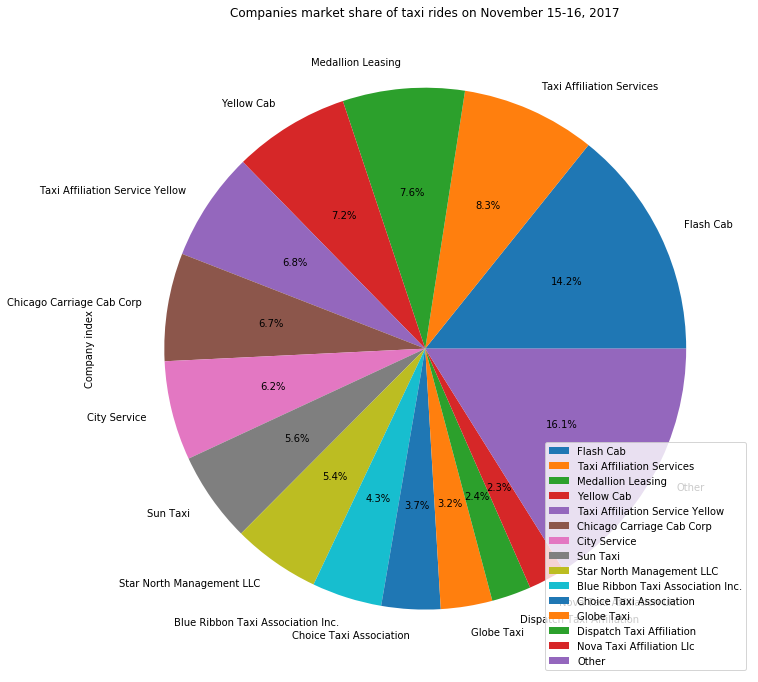

In [20]:
# pie plot of companies' share of rides on November 15-17, 2017: 
companies.plot(kind='pie', y='trips_amount', autopct='%1.1f%%', figsize=(15, 12))
plt.ylabel('Company index')
plt.title('Companies market share of taxi rides on November 15-16, 2017')
plt.legend(loc = 'lower right')
plt.show()  

The market leader (Flash cab) has 14.2% of the rides, while the next one (Taxi Affiliation Services) has only 8.3%, and the following companies have similar (and gradually dropping) market shares of the rides. As the pie shows - 6 leading companies hold half of the market, and with 5 more (11 all together) they hold about 3/4 of all rides. 

## Testing hypothesis

### The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays

First we will load the Saturday rides / weather conditions data: 

In [21]:
# Load the data file into a DataFrame, and look at a sample:
sat_rides = pd.read_csv('/datasets/project_sql_result_07.csv')
sat_rides.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.00
1,2017-11-25 14:00:00,Good,1920.00
2,2017-11-25 12:00:00,Good,1543.00
3,2017-11-04 10:00:00,Good,2512.00
4,2017-11-11 07:00:00,Good,1440.00


In [22]:
# general info of this table:
sat_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
start_ts              1068 non-null object
weather_conditions    1068 non-null object
duration_seconds      1068 non-null float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


No missing values. For our purposes the datatypes are ok, because for the hypothesis we don't need 'start_ts' column (so we don't need now to change it into 'datetime').

We will use a test for hypothesis on the equality of two independant population means.

Our null hypothesis to test will be:

**The average duration of rides from the Loop to O'Hare International Airport on rainy and good-weather Saturdays are equal**

The alternative hypothesis is:

The average duration of rides from the Loop to O'Hare International Airport on rainy and good-weather Saturdays are not equal

first we will check th mean and variance of the rides duration between the two weather conditions:



In [23]:
# Compare the mean and the variance of the rides duration between the two weather conditions:
sat_rides_stats = sat_rides.pivot_table(
    index='weather_conditions', values='duration_seconds', aggfunc=['mean', 'var'])
sat_rides_stats

,mean,var
,duration_seconds,duration_seconds
weather_conditions,,
Bad,2427.21,520294.09
Good,1999.68,576382.01


The average Saturday ride in bad (rain or storm) weather (2427.21 sec) is ~21% longer than in good weather (1999.68 sec). 
The question is wether this difference can be random - and for this we will run the statistical test. Since the variance is close enough - we will keep 'equal_var' in the statistical test on it's default True value. We will set significance level on 0.05, as common, since there is no special reason to set a different level. 

In [24]:
# Test the hypothesis about mean equality:
good = sat_rides.query('weather_conditions == "Good"')['duration_seconds'] 
bad = sat_rides.query('weather_conditions == "Bad"')['duration_seconds']

alpha = 0.05

results = st.ttest_ind(
    good,
    bad)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print(
        "We reject the null hypothesis"
    )
else:
    print(
        "We can't reject the null hypothesis"
    )

p-value:  6.517970327099473e-12
We reject the null hypothesis


We can see that the p-value is very small, and smaller than our set significance level alpha, which means that our statistical test shows that the probabillity that the difference between the means is random - is very low, therefore **we reject the hypothsis that the means are equal**.

## General conclusion

1. **Project goal**: To understand taxi passenger preferences and patterns and the impact of weather on rides duration. 

2. **Data**: 3 tables of sorted data, that were created earlier using SQL, were analysed:
    - Companies: the number of rides for each taxi company on November 15-16, 2017 (64 entries).

    - Neighborhoods: the average number of rides that ended in each neighborhood in November 2017 (94 entries). 

    - Saturday_rides: rides durations from the Loop to O'Hare International Airport on November 2017 Saturdays, and the weather conditions for each ride day 


3. **The top 10 neighborhoods in terms of drop-offs**

        1. Loop --------------------19.0% of average number of rides (drop-offs)    
        2. River North -----------16.9%
        3. Streeterville -----------11.8%
        4. West Loop --------------9.2%
        5. O'Hare ------------------ 4.5%
        6. Lake View ---------------4.3%
        7. Grant Park ---------------3.7%
        8. Museum Campus -------2.7%
        9. Gold Coast ---------------2.4%
        10. Sheffield & DePaul ------2.2%

and the next 2 are also close enogh to number 10:

    11. Lincoln Park ------------2.2%
    12. East Village ------------2.1%
    13. Other (all the rest)----19.0%

Only 4 neighborhoods (Loop, River North, Streeterville and West Loop) make together almost 57% of all rides drop-offs. The fifth (O'Hare) is the destiny of only 4.5% of the rides. The big majority of all 64 neighborhoods are each the destiny of a very small share of rides 

4. **Taxi companies and number of rides**: 
The big majority of rides are done by about 10 companies, while many companies make a relatively small amount of rides. One company (Flash cab) leads way ahead of all the rest (almost 20K rides in these two days, 14.2% of the rides), followed by 'Taxi Affiliation Services' with only around 11K rides (8.3%), and the following companies have similar (and gradually dropping) market shares of the rides. 
The 6 leading companies hold together half of the market, and with 5 more (11 all together) they hold about 3/4 of all rides.

5. **Testing hypothesis: The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays**:
The average Saturday ride in bad (rain or storm) weather (2427.21 sec) is ~21% longer than in good weather (1999.68 sec). We checked if this difference could be random. 
We used a test for hypothesis on the equality of two independant population means.

Our null hypothesis to test was:

The average duration of rides from the Loop to O'Hare International Airport on rainy and good-weather Saturdays are equal.

our statistical test shows that the probabillity that the difference between the means is random - is very low, therefore **we reject the hypothsis that the means are equal**.



